# 1.
Load the MNIST dataset,take the first 60,000 instances for training, and the remaining 10,000 for testing. 
Train a random forest classifier on the dataset and time how long it takes, evaluate the resulting model on the test set. 
Use PCA to reduce the dataset’s dimensionality, with an explained variance ratio of 95%. Train a new random forest classifier on the reduced dataset and see how long it takes. 
# Was training much faster? 
# Evaluate the classifier on the test set. How does it compare to the previous classifier? 
# Try again with an SGDClassifier. How much does PCA help now?

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier

In [2]:
# Load the MNIST dataset 
mnist = fetch_openml('mnist_784', as_frame=False)

In [3]:
# take the first 60,000 instances for training, and the remaining 10,000 for testing
X_train = mnist.data[:60000]
y_train = mnist.target[:60000]

X_test = mnist.data[60000:]
y_test = mnist.target[60000:]

In [4]:
# Train a Random Forest classifier on the dataset and time how long it takes
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [5]:
%time rnd_clf.fit(X_train, y_train)

CPU times: user 40.2 s, sys: 156 ms, total: 40.3 s
Wall time: 40.6 s


RandomForestClassifier(random_state=42)

In [6]:
# Evaluate the resulting model on the test set.
y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9705

In [7]:
# use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%.
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

In [8]:
# Train a new Random Forest classifier on the reduced dataset and see how long it takes
rnd_clf_with_pca = RandomForestClassifier(n_estimators=100, random_state=42)
%time rnd_clf_with_pca.fit(X_train_reduced, y_train)

CPU times: user 1min 32s, sys: 1.35 s, total: 1min 33s
Wall time: 1min 37s


RandomForestClassifier(random_state=42)

Oh no! Training is actually about twice slower now! How can that be? Well, as we saw in this chapter, dimensionality reduction does not always lead to faster training time: it depends on the dataset, the model and the training algorithm. If you try SGDClassifier instead of RandomForestClassifier, you will find that training time is reduced by a factor of 3 when using PCA. Actually, we will do this in a second, but first let's check the precision of the new random forest classifier.

In [9]:
# Next evaluate the classifier on the test set
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf_with_pca.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9481

It is common for performance to drop slightly when reducing dimensionality, because we do lose some potentially useful signal in the process. However, the performance drop is rather severe in this case. So PCA really did not help: it slowed down training *and* reduced performance. 😭

# Try again with an SGDClassifier

In [10]:
sgd_clf = SGDClassifier(random_state=42)
%time sgd_clf.fit(X_train, y_train)

CPU times: user 3min 9s, sys: 5.54 s, total: 3min 15s
Wall time: 3min 25s


SGDClassifier(random_state=42)

In [11]:
y_pred = sgd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.874

Okay, so the SGDClassifier takes much longer to train on this dataset than the RandomForestClassifier, plus it performs worse on the test set. But that's not what we are interested in right now, we want to see how much PCA can help SGDClassifier. Let's train it using the reduced dataset:

In [14]:
sgd_clf_with_pca = SGDClassifier(random_state=42)
%time sgd_clf_with_pca.fit(X_train_reduced, y_train)

CPU times: user 45.8 s, sys: 1.94 s, total: 47.7 s
Wall time: 50.5 s


SGDClassifier(random_state=42)

Nice! Reducing dimensionality led to roughly 5× speedup. :) Let's check the model's accuracy:

In [15]:
y_pred = sgd_clf_with_pca.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.8959

Great! PCA not only gave us a 5× speed boost, it also improved performance slightly.

So there you have it: PCA can give you a formidable speedup, and if you're lucky a performance boost... but it's really not guaranteed: it depends on the model and the dataset!

# Extra

# 2.
Use t-SNE to reduce the first 5,000 images of the MNIST dataset down to 2
dimensions and plot the result using Matplotlib. You can use a scatterplot using
10 different colors to represent each image’s target class. Alternatively, you can
replace each dot in the scatterplot with the corresponding instance’s class (a digit
from 0 to 9), or even plot scaled-down versions of the digit images themselves
(if you plot all digits the visualization will be too cluttered, so you should either
draw a random sample or plot an instance only if no other instance has already
been plotted at a close distance). You should get a nice visualization with wellseparated
clusters of digits. Try using other dimensionality reduction algorithms,
such as PCA, LLE, or MDS, and compare the resulting visualizations.

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [17]:
# Let's limit ourselves to the first 5,000 images of the MNIST training set, to speed things up a lot.
X_sample, y_sample = X_train[:5000], y_train[:5000]

In [18]:
# Let's use t-SNE to reduce dimensionality down to 2D so we can plot the dataset:
tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
%time X_reduced = tsne.fit_transform(X_sample)

CPU times: user 52 s, sys: 1.87 s, total: 53.9 s
Wall time: 28.1 s


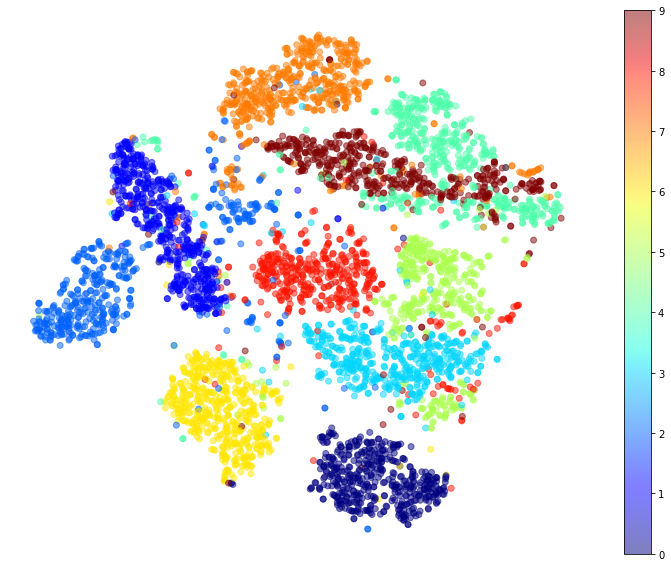

In [19]:
# Now let's use Matplotlib's scatter() function to plot a scatterplot, using a different color for each digit:
plt.figure(figsize=(13, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1],
            c=y_sample.astype(np.int8), cmap="jet", alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()

Isn't this just beautiful? :) Most digits are nicely separated from the others, even though t-SNE wasn't given the targets: it just identified clusters of similar images. But there is still a bit of overlap. For example, the 3s and the 5s overlap a lot (on the right side of the plot), and so do the 4s and the 9s (in the top-right corner).

# Let's focus on just the digits 4 and 9 and see if we can produce a nicer image by running t-SNE on just these 2 digits

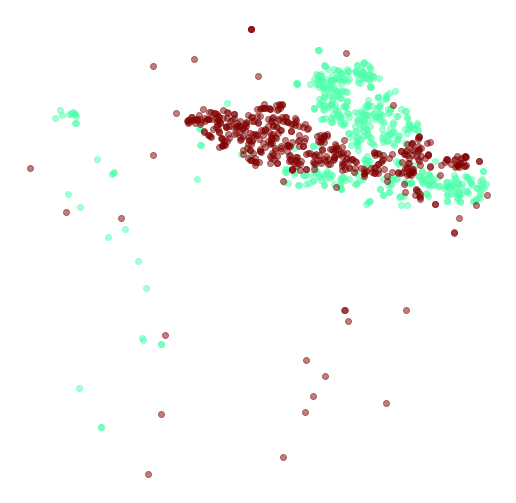

In [20]:
plt.figure(figsize=(9, 9))
cmap = plt.cm.jet
for digit in ('4', '9'):
    plt.scatter(X_reduced[y_sample == digit, 0], X_reduced[y_sample == digit, 1],
                c=[cmap(float(digit) / 9)], alpha=0.5)
plt.axis('off')
plt.show()

In [21]:
idx = (y_sample == '4') | (y_sample == '9')
X_subset = X_sample[idx]
y_subset = y_sample[idx]

tsne_subset = TSNE(n_components=2, init="random", learning_rate="auto",
                   random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

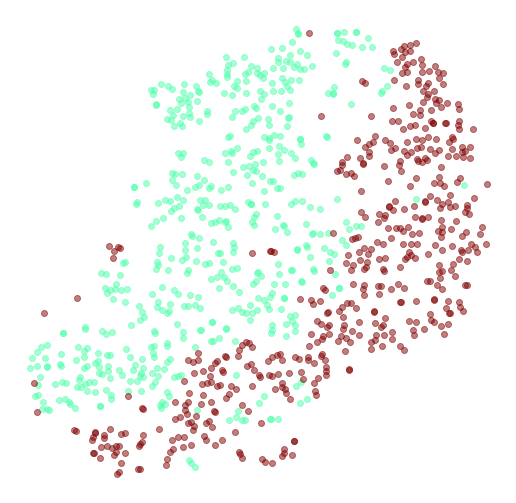

In [22]:
plt.figure(figsize=(9, 9))
for digit in ('4', '9'):
    plt.scatter(X_subset_reduced[y_subset == digit, 0],
                X_subset_reduced[y_subset == digit, 1],
                c=[cmap(float(digit) / 9)], alpha=0.5)
plt.axis('off')
plt.show()

That's much better, although there's still a bit of overlap. Perhaps some 4s really do look like 9s, and vice versa. It would be nice if we could visualize a few digits from each region of this plot, to understand what's going on. In fact, let's do that now.

Let's create a `plot_digits()` function that will draw a scatterplot (similar to the above scatterplots) plus write colored digits, with a minimum distance guaranteed between these digits. If the digit images are provided, they are plotted instead. This implementation was inspired from one of Scikit-Learn's excellent examples ([plot_lle_digits](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html), based on a different digit dataset).

In [23]:
def plot_digits(X, y, min_distance=0.04, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = plt.cm.jet
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1],
                    c=[cmap(float(digit) / 9)], alpha=0.5)
    plt.axis("off")
    ax = plt.gca()  # get current axes
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(float(y[index]) / 9),
                         fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"),
                                          image_coord)
                ax.add_artist(imagebox)

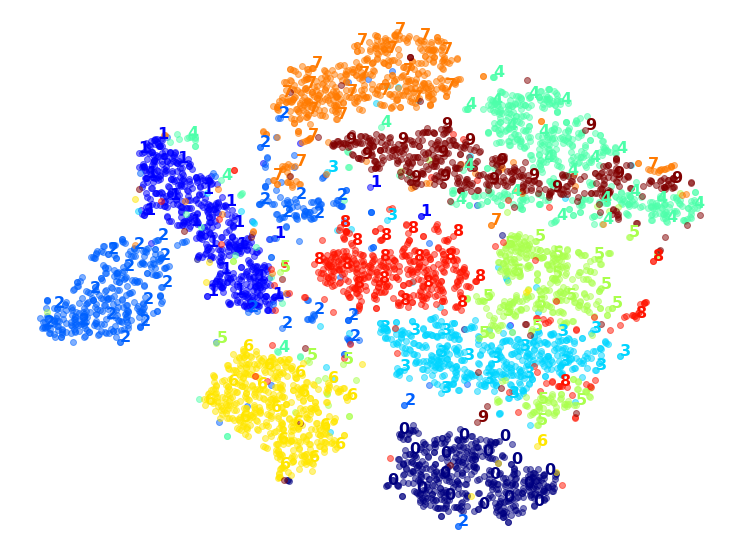

In [24]:
# First let's show colored digits (not images), for all 5,000 images:
plot_digits(X_reduced, y_sample)

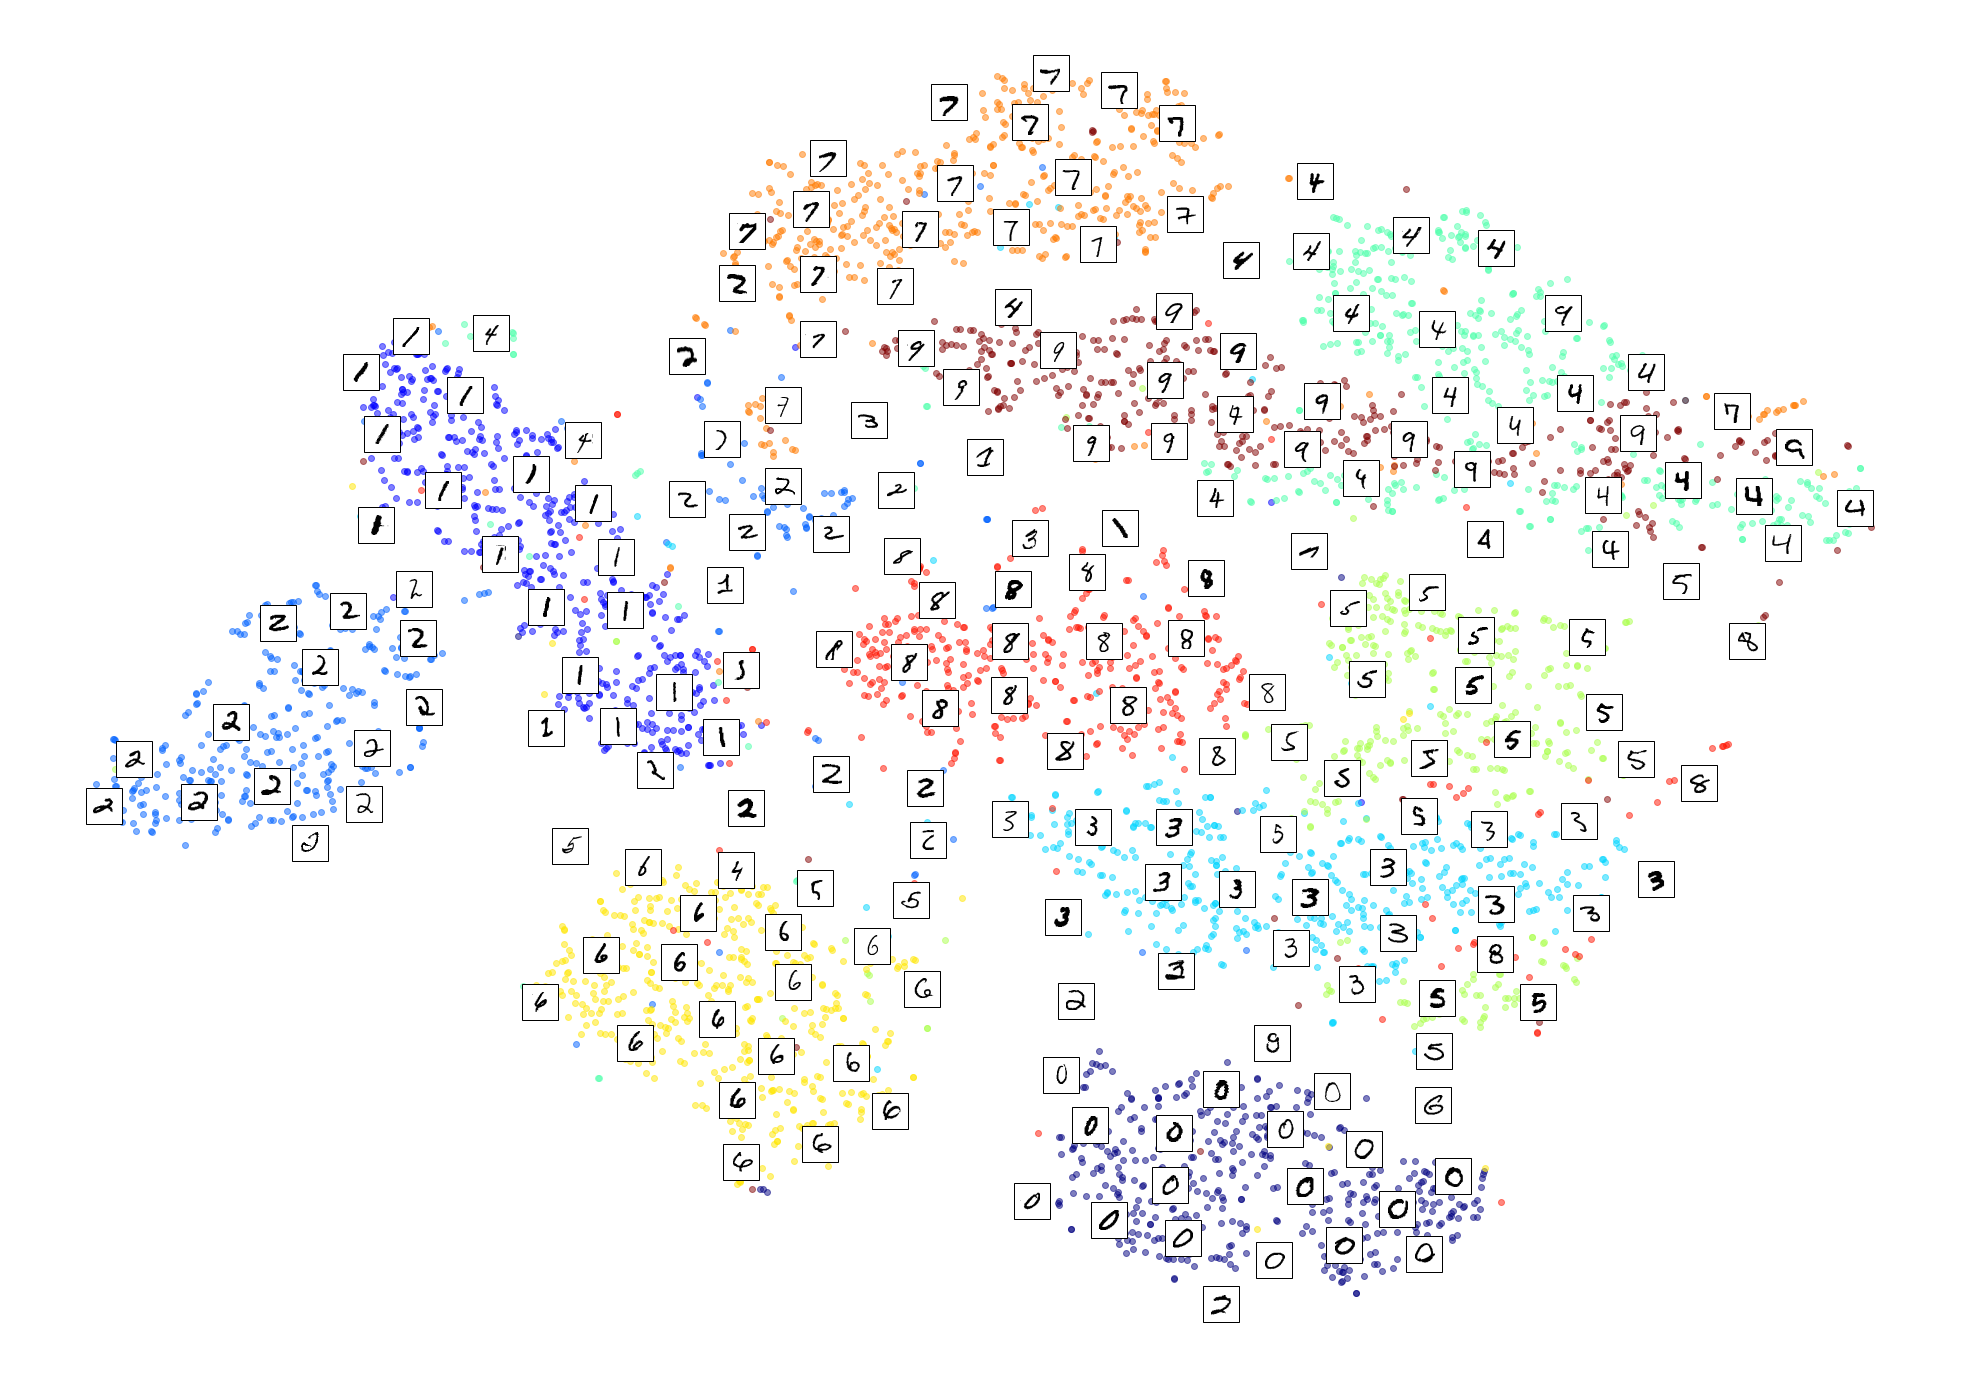

In [25]:
# Well that's okay, but not that beautiful. Let's try with the digit images:
plot_digits(X_reduced, y_sample, images=X_sample, figsize=(35, 25))

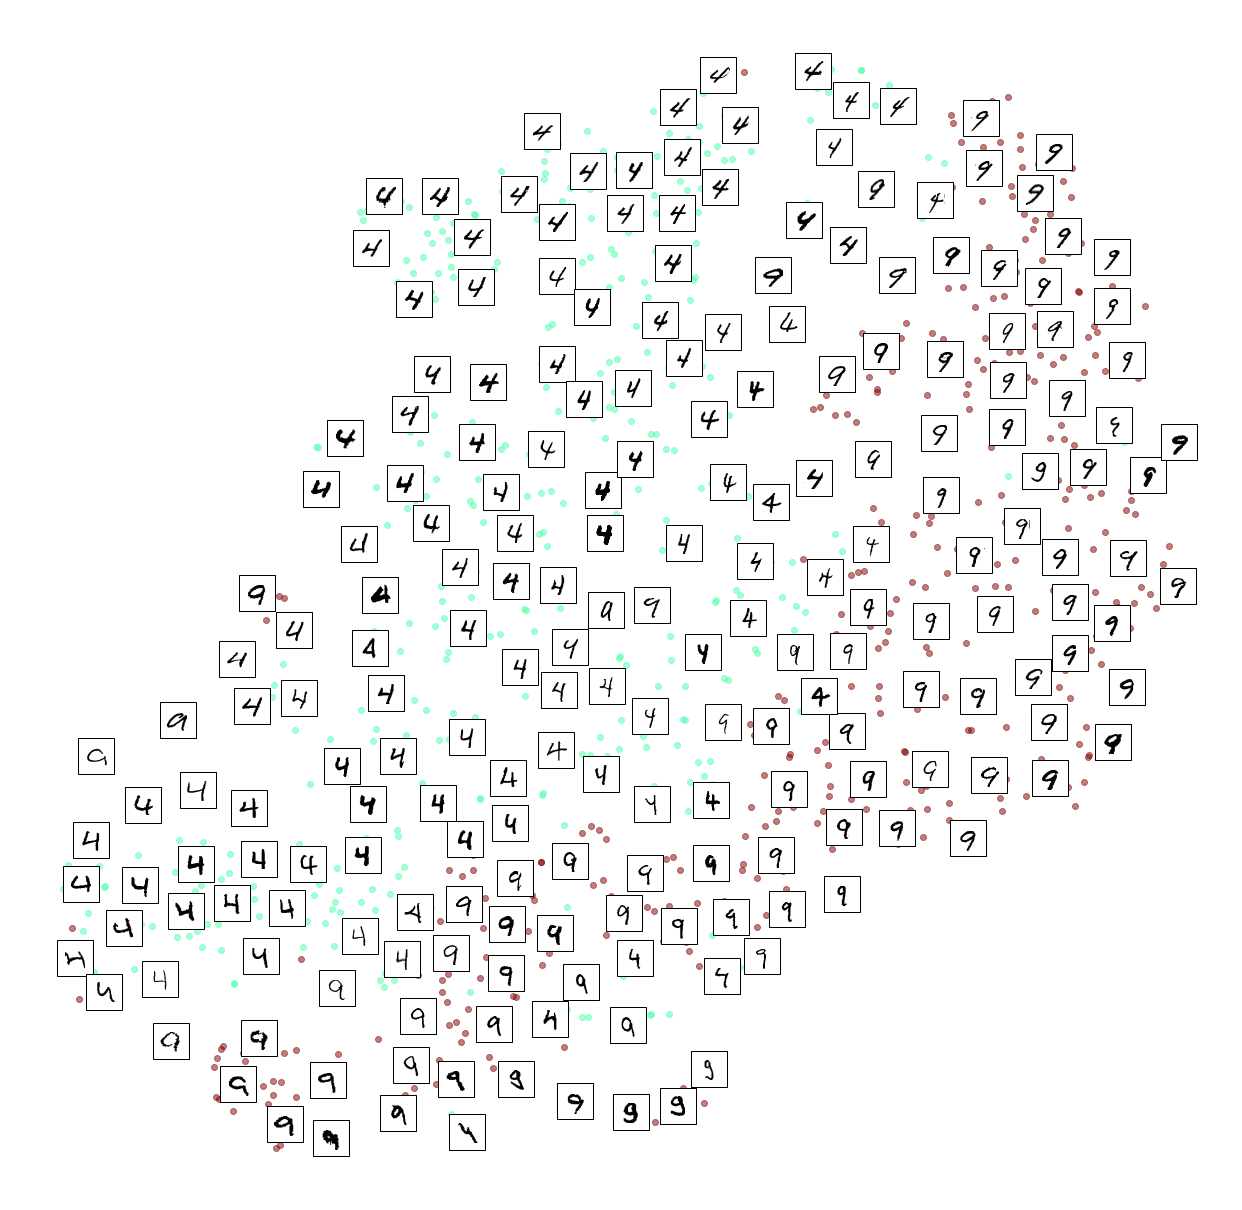

In [26]:
# That's nicer! Now let's focus on just the 4s and the 9s:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

Notice how similar-looking 4s are grouped together. For example, the 4s get more and more inclined as they approach the top of the figure. The inclined 9s are also closer to the top. Some 4s really do look like 9s, and vice versa.

# Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations.

CPU times: user 845 ms, sys: 2.14 s, total: 2.98 s
Wall time: 1.48 s


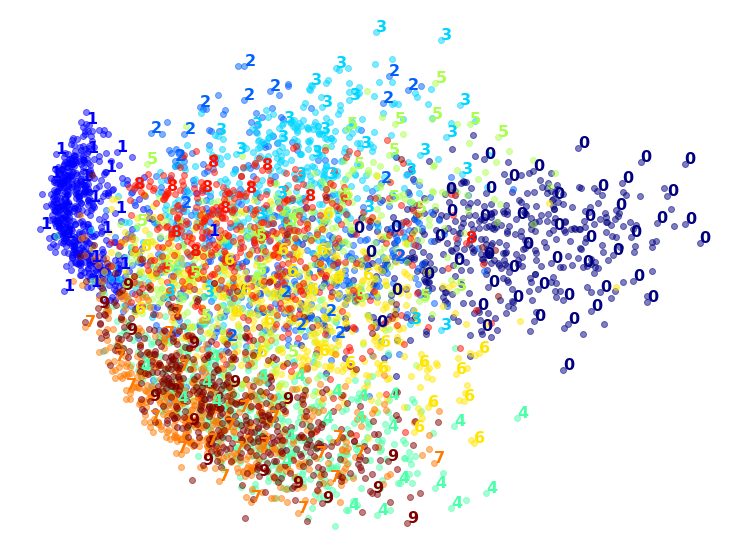

In [27]:
# Let's start with PCA. We will also time how long it takes:
pca = PCA(n_components=2, random_state=42)
%time X_pca_reduced = pca.fit_transform(X_sample)
plot_digits(X_pca_reduced, y_sample)
plt.show()

Wow, PCA is blazingly fast! But although we do see a few clusters, there's way too much overlap. Let's try LLE:

CPU times: user 1min 23s, sys: 9min 21s, total: 10min 44s
Wall time: 5min 23s


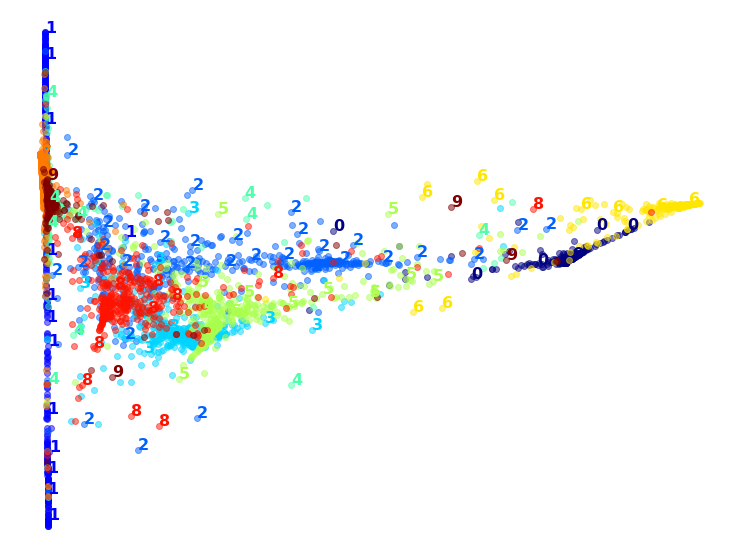

In [34]:
lle = LocallyLinearEmbedding(n_components=2, random_state=42)
%time X_lle_reduced = lle.fit_transform(X_sample)
plot_digits(X_lle_reduced, y_sample)
plt.show()

That took more time, and yet the result does not look good at all. Let's see what happens if we apply PCA first, preserving 95% of the variance:

CPU times: user 1min 43s, sys: 11min 55s, total: 13min 39s
Wall time: 6min 50s


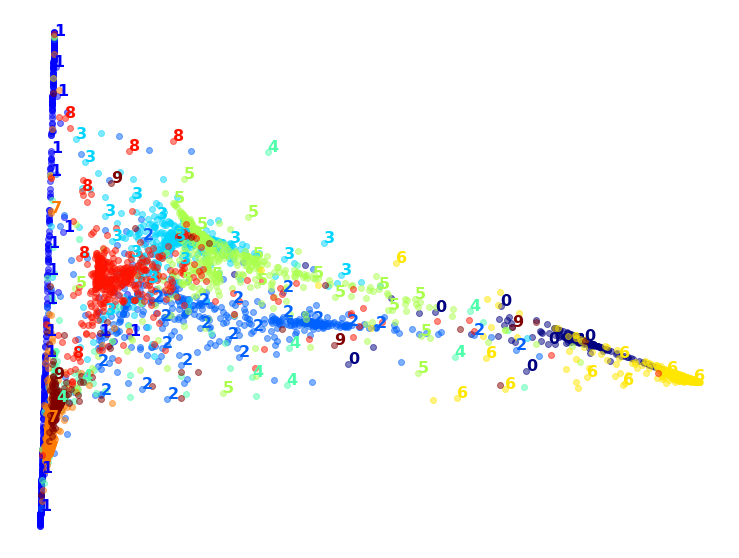

In [35]:
pca_lle = make_pipeline(PCA(n_components=0.95),
                        LocallyLinearEmbedding(n_components=2, random_state=42))

%time X_pca_lle_reduced = pca_lle.fit_transform(X_sample)
plot_digits(X_pca_lle_reduced, y_sample)
plt.show()

The result is more or less as bad, but this time training was a bit faster. Let's try LDA now:

CPU times: user 20.4 s, sys: 2min 13s, total: 2min 33s
Wall time: 1min 17s


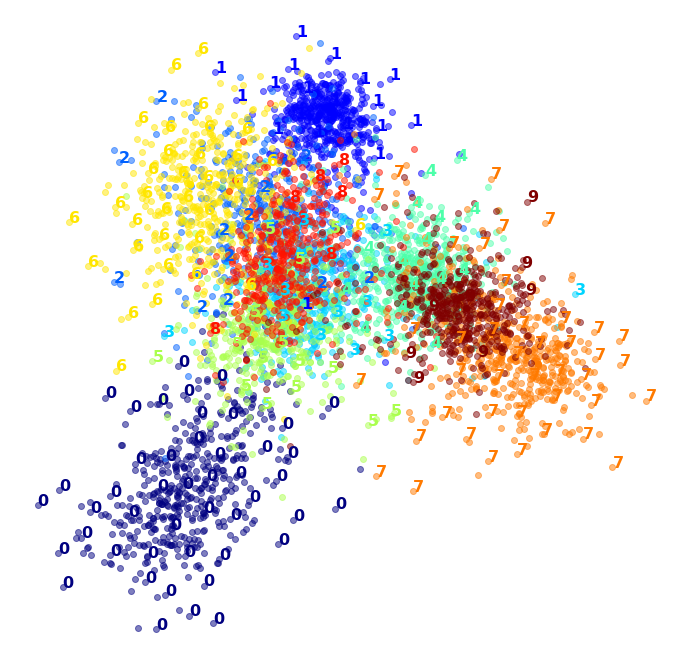

In [36]:
lda = LinearDiscriminantAnalysis(n_components=2)
%time X_lda_reduced = lda.fit_transform(X_sample, y_sample)
plot_digits(X_lda_reduced, y_sample, figsize=(12, 12))
plt.show()

This one is very fast, and it looks nice at first, until you realize that several clusters overlap severely.

# Well, it's pretty clear that t-SNE won this little competition, wouldn't you agree?